# Denoising Sampler

For a distribution F with known density f(x), find a distribution $G_\theta \in \mathcal{G}$(parameterized by $\theta$) that best approximates $F$.
With stochastic gradient descent, for each iteration:
1. Sample $\epsilon \sim N(0, I)$
2. Compute $x = \mu + L\epsilon$
3. Evaluate $\log{f(x)}$ and $\log{g(x)}$
4. Compute gradients of the loss $\log{f(x)} - \log{g(x)}$ with respect to $\theta$
5. Update $\theta$

In [ ]:
# Autoreload all modules
%load_ext autoreload
%autoreload 2

import numpy as np  

import jax
import jax.numpy as jnp
import jax.random as jr

from flax import linen as nn
from flax.training import train_state
import optax
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams['animation.ffmpeg_path'] = r'C:\Users\Hangao Liang\ffmpeg\bin\ffmpeg.exe'

import sys
sys.path.append('../../')

from mcjax.proba.gaussian import IsotropicGauss, Gauss
from mcjax.proba.neal_funnel import NealFunnel
from mcjax.proba.student import Student
from mcjax.proba.banana2d import Banana2D

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
# Distribution F
dim = 2
mu_0 = jnp.ones(dim)
sigma_0 = 0.9
cov = jnp.array([[1, sigma_0], [sigma_0, 1]])

logF = Gauss(mu_0, cov)

class VarInference():

    def __init__(self):
        pass

    def init_params(self, key, lr=1e-3):
        mu = jr.normal(key, (dim,))
        # Lower triangular matrix L @ L^T = Cov
        L = jnp.eye(dim) * 0.5
        # L = jr.normal(key, (dim, dim))  

        tx = optax.adam(lr)
        return train_state.TrainState.create(apply_fn=self.compute_loss,\
                                            params=(mu, L), tx=tx)
        

    def compute_loss(self, params, key, num_samples=1000):
        # reparametrization
        mu, L = params
        dim = len(mu)
        eps = jr.normal(key, (num_samples, dim))
        x = mu + jnp.einsum('ij,bj->bi', L, eps)  # L @ eps.T
        
        # Use multivariate normal logpdf
        log_g = jax.scipy.stats.multivariate_normal.logpdf(x, mu, jnp.dot(L, L.T))
        log_f = logF.batch(x)
        return jnp.mean(log_g - log_f)
    
    def update(self, state, key):
        loss, grad = jax.value_and_grad(state.apply_fn)(state.params, key)
        return state.apply_gradients(grads=grad), loss

    def train(self, key, num_steps=1000):
        key, key_ = jr.split(key)
        state = self.init_params(key_)    
        loss_list = []
        state_list = []
        for i in range(num_steps):
            key, key_ = jr.split(key)
            state, loss = self.update(state, key_)
            state_list.append(state.params)
            loss_list.append(loss)
            if i % 100 == 0:
                print(f'Step {i}, Loss: {loss}')
        return state, state_list, loss_list


Step 0, Loss: 2.8496639728546143
Step 100, Loss: 2.055581569671631
Step 200, Loss: 1.4006587266921997
Step 300, Loss: 1.0582717657089233
Step 400, Loss: 0.8493536710739136
Step 500, Loss: 0.7609294652938843
Step 600, Loss: 0.664831817150116
Step 700, Loss: 0.6174127459526062
Step 800, Loss: 0.5780654549598694
Step 900, Loss: 0.5118985176086426
Step 1000, Loss: 0.46742865443229675
Step 1100, Loss: 0.4651268422603607
Step 1200, Loss: 0.40298524498939514
Step 1300, Loss: 0.39187002182006836
Step 1400, Loss: 0.3309687674045563
Step 1500, Loss: 0.23342296481132507
Step 1600, Loss: 0.2630169689655304
Step 1700, Loss: 0.27330511808395386
Step 1800, Loss: 0.17961090803146362
Step 1900, Loss: 0.17163535952568054
Step 2000, Loss: 0.13078145682811737
Step 2100, Loss: 0.12428395450115204
Step 2200, Loss: 0.1179494708776474
Step 2300, Loss: 0.08821290731430054
Step 2400, Loss: 0.08061673492193222
Step 2500, Loss: 0.05156925693154335
Step 2600, Loss: 0.05040258914232254
Step 2700, Loss: 0.0335009098

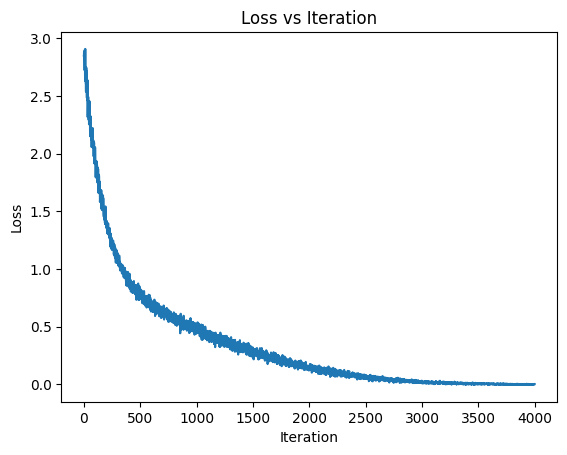

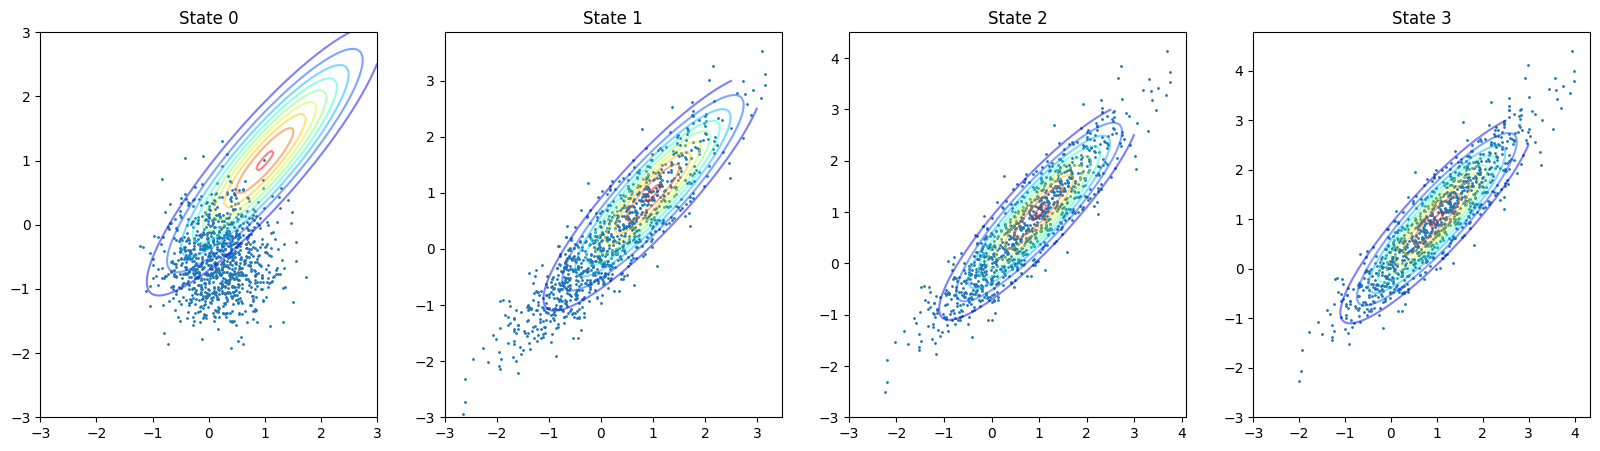

In [33]:
varinf = VarInference() 
key = jr.key(0)
num_steps = 4000
final_state, state_list, loss_list = varinf.train(key, num_steps)
mu = final_state.params[0]
L = final_state.params[1]
var = jnp.dot(L, L.T)
print('mu:', mu)
print('var:', var)

# Plot the loss
plt.plot(loss_list)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss vs Iteration')

# plot the initial, 1/3, 2/3, and final states (for dim=2)
def plot_states(states, num_samples=1000):
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    for i, state in enumerate(states):
        mu = state[0]
        L = state[1]
        dim = len(mu)
        eps = jr.normal(key, (num_samples, dim))
        x = mu + jnp.einsum('ij,bj->bi', L, eps)  
        ax[i].scatter(x[:, 0], x[:, 1], s=1)
        ax[i].set_title(f'State {i}')
        # plot the contour of the target distribution
        x1 = np.linspace(-3, 3, 100)
        x2 = np.linspace(-3, 3, 100)    
        X1, X2 = np.meshgrid(x1, x2)
        pos = np.dstack((X1, X2))
        pos = np.reshape(pos, (-1, 2))
        Z = np.exp(logF.batch(pos))
        Z = Z.reshape(X1.shape)
        ax[i].contour(X1, X2, Z, levels=10, cmap='jet', alpha=0.5)
    plt.show()

states = [state_list[0], state_list[num_steps//3], state_list[num_steps*2//3], state_list[-1]]
plot_states(states)


### DDPM Model

In [ ]:
T = 1000
dim = 2
batch_size = 64

# define hyper-parameters 
beta_start = 0.0001
beta_end = 0.02
betas = beta_start * (beta_end / beta_start) ** (jnp.linspace(0, 1, T))
alphas = 1 - betas
alpha_bars = jnp.cumprod(alphas)

In [6]:
class MLPModel(nn.Module):
    dim: int
    T: int
    
    def setup(self):
        # Enhanced time embedding
        self.time_embed = nn.Sequential([
            nn.Dense(64),
            nn.relu,
            nn.Dense(256)
        ])
        
        # Main network
        self.layers = [
            nn.Dense(128),
            nn.LayerNorm(),
            nn.relu,
            nn.Dense(128),
            nn.LayerNorm(),
            nn.relu,
            nn.Dense(self.dim)
        ]

    def __call__(self, x, t):
        # Sinusoidal time embedding
        half_dim = 32
        emb = jnp.log(10000) / (half_dim - 1)
        emb = jnp.exp(jnp.arange(half_dim) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = jnp.concatenate([jnp.sin(emb), jnp.cos(emb)], axis=-1)
        t_embed = self.time_embed(emb)
        
        x = jnp.concatenate([x, t_embed], axis=-1)
        for layer in self.layers:
            x = layer(x)
        return x

In [8]:
def create_train_state(model, key):
    t = jnp.zeros((batch_size,), dtype=jnp.int32)
    params = model.init(key, jnp.ones((batch_size, dim)), t)['params']
    tx = optax.chain(
        optax.clip(1.0),
        optax.adam(1e-4)
    )
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

def compute_loss(params, apply, key, x0):
    batch_size = x0.shape[0]
    key1, key2 = jr.split(key, 2)
    noise = jr.normal(key1, x0.shape)

    # choose a random time step
    t = jr.randint(key2, (batch_size,), 0, T)

    # forward process
    alpha_t = alpha_bars[t].reshape(-1, *([1]*(len(x0.shape)-1)))
    xt = jnp.sqrt(alpha_t)*x0 \
        + jnp.sqrt(1-alpha_t)*noise
    
    pred_noise = apply({"params": params}, xt, t)
    return jnp.mean(jnp.sum((pred_noise - noise)**2, axis=1))

# training loop
def train_step(state, batch, key):
    loss, grad = jax.value_and_grad(compute_loss)(state.params, state.apply_fn, key, batch)
    return state.apply_gradients(grads=grad), loss

# sampling function
def sample(model, params, key, dim, num_samples=1000):
    key, key_ = jr.split(key)
    samples = jr.normal(key_, (num_samples,dim))
    samples_list = [samples]
    for t in reversed(range(T)):
        t_arr = jnp.full((num_samples,), t)
        pred_noise = model.apply({'params': params}, samples, t_arr)

        # reverse step
        samples = (samples - 
                   (betas[t]/jnp.sqrt(1-alpha_bars[t])) * pred_noise) / jnp.sqrt(alphas[t]) 
        if t > 0:
            key, key_ = jr.split(key)
            samples += jnp.sqrt(betas[t])*jr.normal(key_, (num_samples,dim))
        
        samples_list.append(samples)

    return samples_list

# toy dataset
def create_dataset(key, num_samples=1000):
    key, key_ = jr.split(key)
    theta = jr.uniform(key_, (num_samples,)) * 2 * jnp.pi
    x = jnp.stack([jnp.cos(theta), jnp.sin(theta)], axis=1)
    x += 0.1 * jax.random.normal(key, (num_samples, 2))
    return x


In [9]:
def train(model, key, init_state, dataset, num_steps=1000, num_samples=1000):
    state = init_state
    num_batches = len(dataset) // batch_size
    dataset_trimmed = dataset[:num_batches*batch_size]
    batches = jnp.split(dataset_trimmed, num_batches)
    losslist = []

    for epoch in range(num_steps):
        epoch_loss = 0.
        for batch in batches:
            key, key_ = jr.split(key)
            state, loss = train_step(state, batch, key_)
            epoch_loss += loss
        losslist.append(epoch_loss)
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {epoch_loss}')
    
    # plot loss
    plt.plot(losslist, label='Loss', color='blue', alpha=0.7)
    plt.title('Loss')
    plt.legend()
    
    return model, state

Epoch 0, Loss: 200.39852905273438
Epoch 10, Loss: 72.16392517089844
Epoch 20, Loss: 73.74102020263672
Epoch 30, Loss: 73.65375518798828
Epoch 40, Loss: 68.73731231689453
Epoch 50, Loss: 71.60936737060547
Epoch 60, Loss: 68.67587280273438
Epoch 70, Loss: 71.2933578491211
Epoch 80, Loss: 68.75927734375
Epoch 90, Loss: 69.5174560546875
Epoch 100, Loss: 69.32003784179688
Epoch 110, Loss: 66.46233367919922
Epoch 120, Loss: 64.3402099609375
Epoch 130, Loss: 62.76333236694336
Epoch 140, Loss: 60.98699951171875
Epoch 150, Loss: 59.76120376586914
Epoch 160, Loss: 59.182823181152344
Epoch 170, Loss: 62.1970329284668
Epoch 180, Loss: 59.79180908203125
Epoch 190, Loss: 58.5925407409668
Epoch 200, Loss: 60.76206970214844
Epoch 210, Loss: 60.122982025146484
Epoch 220, Loss: 62.34274673461914
Epoch 230, Loss: 60.982330322265625
Epoch 240, Loss: 60.0783805847168
Epoch 250, Loss: 60.82652282714844
Epoch 260, Loss: 59.35148239135742
Epoch 270, Loss: 61.92668151855469
Epoch 280, Loss: 58.62511444091797
E

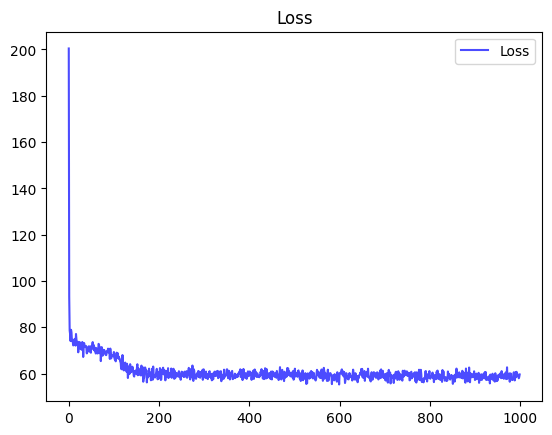

In [22]:
model = MLPModel(dim, T)
num_samples = 10000
num_steps = 1000

key = jr.key(0)
key, key_ = jr.split(key)
state = create_train_state(model, key_)
key, key_ = jr.split(key)
dataset = create_dataset(key_, num_samples)

key, key_ = jr.split(key)
_, final_state = train(model, key_, state, dataset, num_steps=num_steps, num_samples=num_samples)


In [27]:
# sample from the model
samples_list = sample(model, final_state.params, key, dim)

Text(0.5, 1.0, 'Original vs Sampled Data at T=0')

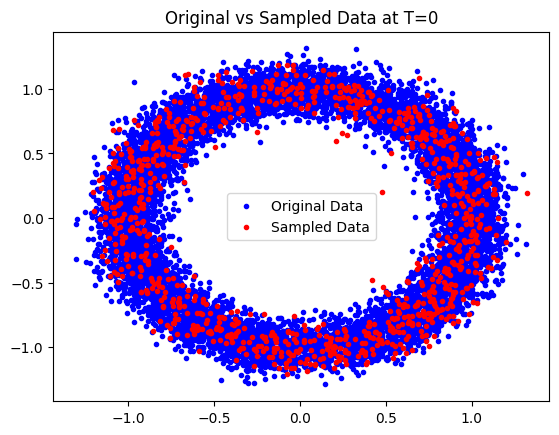

In [28]:
plt.scatter(dataset[:,0], dataset[:,1], marker='.', color='b', label='Original Data')
plt.scatter(samples_list[-1][:,0], samples_list[-1][:,1], marker='.', color = 'r', label='Sampled Data')
plt.legend()
plt.title('Original vs Sampled Data at T=0')

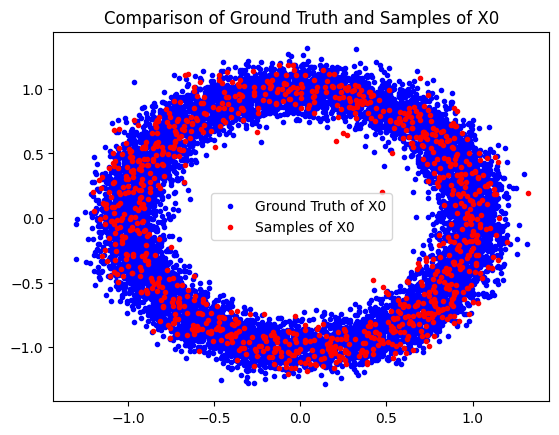

In [25]:
# Create figure and axis
fig, ax = plt.subplots()
ax.set_title('Comparison of Ground Truth and Samples of X0')

# Plot static ground truth
sc1 = ax.scatter(dataset[:, 0], dataset[:, 1], marker='.', color='blue', label='Ground Truth of X0')
sc2 = ax.scatter([], [], marker='.', color='red', label='Samples of X0')

# Add legend
ax.legend()

# Update function for animation
def update(frame):
    sc2.set_offsets(samples_list[frame]) 
    return sc2,

# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(samples_list), interval=200, blit=True)
ani.save("scatter_animation.mp4",writer='ffmpeg') 

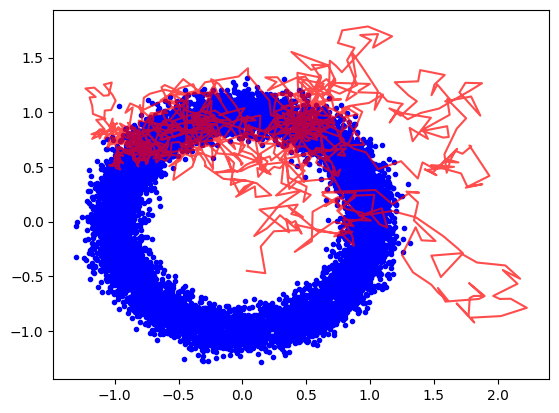

In [26]:
# draw the trajectory of one sampled particle
plt.figure()
index = 0
plt.plot([x[index,0] for x in samples_list], [x[index,1] for x in samples_list], color='red',alpha=0.7)
plt.scatter(dataset[:, 0], dataset[:, 1], marker='.', color='blue', label='Ground Truth of X0')